## TP 3 - NLP - Parte 1: PALABRAS

Consigna

Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.

Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.

Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.

Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


Sugerencias

Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.

Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.

rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.

In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [2]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/NLP CEIA/Agatha_Christie_TheMuerderOfRogerAckroyd.txt'

Mounted at /content/drive


In [6]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv(file_path, sep='/n', header=None)
df.head(30)

<ipython-input-6-52eba8e7f133>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(file_path, sep='/n', header=None)


,0
0,The Project Gutenberg eBook of The murder of R...
1,This ebook is for the use of anyone anywhere i...
2,most other parts of the world at no cost and w...
3,"whatsoever. You may copy it, give it away or r..."
4,of the Project Gutenberg License included with...
5,at www.gutenberg.org. If you are not located i...
6,you will have to check the laws of the country...
7,before using this eBook.
8,Title: The murder of Roger Ackroyd
9,Author: Agatha Christie


In [7]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 7592


In [8]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from tensorflow.keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from tensorflow.keras.utils import pad_sequences # se utilizará para padding

In [9]:
# cada verso lo guardamos en una lista
text = list(df.loc[:,0])
text

['The Project Gutenberg eBook of The murder of Roger Ackroyd',
 'This ebook is for the use of anyone anywhere in the United States and',
 'most other parts of the world at no cost and with almost no restrictions',
 'whatsoever. You may copy it, give it away or re-use it under the terms',
 'of the Project Gutenberg License included with this ebook or online',
 'at www.gutenberg.org. If you are not located in the United States,',
 'you will have to check the laws of the country where you are located',
 'before using this eBook.',
 'Title: The murder of Roger Ackroyd',
 'Author: Agatha Christie',
 'Release date: October 2, 2022 [eBook #69087]',
 'Most recently updated: January 31, 2024',
 'Language: English',
 'Original publication: United States: Grosset & Dunlap',
 'Credits: Emmanuel Ackerman, Robert Tonsing and the Online Distributed Proofreading Team at https://www.pgdp.net (This book was produced from images made available by the HathiTrust Digital Library.)',
 '*** START OF THE PROJ

In [10]:
# segmentamos el texto con la utilidad de Keras
segmented_sentences = [text_to_word_sequence(sentence) for sentence in text]

In [11]:
print(text[0])
print (segmented_sentences[0])

The Project Gutenberg eBook of The murder of Roger Ackroyd
['the', 'project', 'gutenberg', 'ebook', 'of', 'the', 'murder', 'of', 'roger', 'ackroyd']


In [12]:
#Quiero ver qué sucede con oraciones con caracteres especiales
print(text[10])
print (segmented_sentences[10])

Release date: October 2, 2022 [eBook #69087]
['release', 'date', 'october', '2', '2022', 'ebook', '69087']


In [13]:
# calculamos la longitud de cada secuencia
length_sentences = [len(sentence) for sentence in segmented_sentences]
length_sentences[10]

7

In [19]:
min(length_sentences)

0

In [20]:
max(length_sentences)

29

In [23]:
from collections import Counter
# Contar las ocurrencias de cada elemento
contador = Counter(length_sentences)

# Obtener el elemento más común
elemento_mas_comun, cantidad = contador.most_common(1)[0]

print(f"El valor que más se repite es: {elemento_mas_comun}, con {cantidad} ocurrencias.")

El valor que más se repite es: 13, con 1127 ocurrencias.


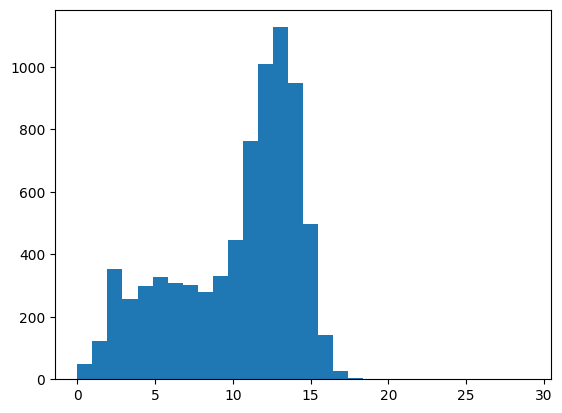

In [16]:
# podemos ver su distribución
plt.hist(length_sentences,bins=30)
plt.show()

In [24]:
max_context_size = int(np.percentile(length_sentences, 90)-1)

# max_context_size = int(np.ceil(np.mean(length_sentences))) # criterio de media
# max_context_size = int(np.ceil(np.median(length_sentences))) # criterio de mediana
print(f'max_context_size: {max_context_size}')

max_context_size: 13


In [25]:
# instanciamos el tokenizador
tok = Tokenizer()

# El tokenizer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado. Se utiliza para designar a palabras
# fuera del vocabulario aprendido
tok.fit_on_texts(segmented_sentences)

# Convertimos las palabras a números
# entran palabras -> salen números
tokenized_sentences = tok.texts_to_sequences(segmented_sentences)

In [26]:
tokenized_sentences[0]

[1, 129, 284, 660, 5, 1, 243, 5, 244, 33]

In [27]:
segmented_sentences[0]

['the',
 'project',
 'gutenberg',
 'ebook',
 'of',
 'the',
 'murder',
 'of',
 'roger',
 'ackroyd']

In [28]:
tokenized_sentences_train, tokenized_sentences_val, _, _ = train_test_split(tokenized_sentences, tokenized_sentences, test_size=0.2, random_state=42)

In [29]:
tok_sent = []

for sent in tokenized_sentences_train:

  # si la secuencia tiene más términos que el tamaño de contexto máximo,
  # armo varias sub-secuencias de tamaño máximo
  if len(sent) > (max_context_size+1):
    extra = len(sent)-(max_context_size+1) + 1
    for i in range(extra):
      tok_sent.append(sent[i:i+max_context_size+1])
  else: # si la secuencia tiene menos términos el tamaño de contexto máximo, dejo la secuencia como está
    tok_sent.append(sent)

In [30]:
len(tok_sent)

6792

In [31]:
tok_sent_augm = []

for sent in tok_sent:

  # generamos todas las sub-secuencias
  subseq = [sent[:i+2] for i in range(len(sent)-1)]
  # en esta línea paddeamos al tamaño de contexto máximo
  tok_sent_augm.append(pad_sequences(subseq, maxlen=max_context_size+1, padding='pre'))

In [33]:
len(tok_sent_augm)

6792

In [34]:
# finalmente concatenamos todas las secuencias en un único array de numpy
train_seqs = np.concatenate(tok_sent_augm, axis=0)

In [35]:
#Tenemos 64 mil seqs con tamaño 14 (13+1)
train_seqs.shape

(64293, 14)

In [77]:
# y de aquí sacamos las entradas y los targets que consumirá nuestro sistema en
# tiempo de entrenamiento
X = train_seqs[:,:-1]
y = train_seqs[:,1:]

In [39]:
X.shape, y.shape

((64293, 13), (64293, 13))

In [48]:
# Palabras del vocabulario
vocab_size=len(tok.index_word)
vocab_size

7175

In [43]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'the': 1, '”': 2, 'i': 3, 'to': 4, 'of': 5, 'a': 6, 'and': 7, 'that': 8, 'you': 9, 'was': 10, 'he': 11, 'it': 12, 'in': 13, 'said': 14, 'is': 15, 'at': 16, 'with': 17, 'me': 18, 'have': 19, 'not': 20, 'his': 21, 'her': 22, 'had': 23, 'she': 24, 'for': 25, 'poirot': 26, 'my': 27, 'as': 28, 'on': 29, 'but': 30, 'be': 31, 'him': 32, 'ackroyd': 33, 'all': 34, '“i': 35, 'been': 36, 'this': 37, 'so': 38, 'one': 39, 'what': 40, 'there': 41, 'from': 42, 'out': 43, 'about': 44, 'by': 45, 'very': 46, 'do': 47, 'know': 48, 'we': 49, 'caroline': 50, 'or': 51, 'no': 52, 'if': 53, 'an': 54, 'up': 55, 'ralph': 56, 'then': 57, 'were': 58, 'man': 59, 'are': 60, 'did': 61, 'mr': 62, '“you': 63, 'flora': 64, 'see': 65, 'miss': 66, 'inspector': 67, 'little': 68, 'has': 69, 'who': 70, 'would': 71, 'must': 72, 'will': 73, 'think': 74, 'any': 75, 'say': 76, 'into': 77, 'mrs': 78, 'when': 79, 'parker': 80, 'asked': 81, 'just': 82, 'some': 83, 'now': 84, 'went': 85, 'your': 86, 'don’t': 87, 'blunt': 88, 'time

In [46]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'ackroyd': 334, 'roger': 44, 'murder': 45, 'gutenberg': 35, 'the': 2729, 'of': 1420, 'ebook': 13, 'project': 83, 'states': 22, 'anywhere': 4, 'in': 910, 'anyone': 5, 'united': 16, 'use': 27, 'and': 1212, 'is': 558, 'for': 440, 'this': 282, 'no': 193, 'almost': 27, 'other': 85, 'with': 518, 'at': 563, 'world': 17, 'restrictions': 2, 'parts': 5, 'cost': 5, 'most': 57, 'or': 192, 'copy': 14, 'whatsoever': 3, 'away': 61, 'give': 45, 'you': 983, 'under': 24, 'terms': 22, 'it': 882, 're': 3, 'may': 79, 'license': 18, 'included': 3, 'online': 5, 'org': 9, 'located': 7, 'are': 168, 'if': 194, 'not': 474, 'www': 10, 'will': 147, 'country': 12, 'check': 4, 'laws': 9, 'to': 1782, 'where': 58, 'have': 481, 'using': 10, 'before': 79, 'title': 1, 'agatha': 2, 'author': 2, 'christie': 2, 'date': 8, '2022': 1, 'october': 1, 'release': 5, '2': 8, '69087': 1, 'recently': 2, 'january': 1, 'updated': 2, '2024': 1, '31': 2, 'language': 5, 'english': 8, 'publication': 2, 'origina

In [84]:
model = Sequential()

# la primera capa es de embedding entrenable. Recordar que se puede variar el tamaño
# del embedding a entrenar
model.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_shape=(None,)))

model.add(LSTM(100, return_sequences=True))
# model.add(Dropout(0.2))

model.add(LSTM(100, return_sequences=True))
# model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida es del tamaño del vocabulario
model.add(Dense(vocab_size+1, activation='softmax'))


# Clasificación multiple categórica --> loss = categorical_crossentropy
# notar que usamos la versión Sparse para utilizar sólo índices en lugar de OHE
model.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)              │ (None, None, 50)            │         358,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, None, 100)           │          60,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, None, 100)           │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, None, 7176)          │         724,776 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,224,376 (4.67 MB)

 Trainable params: 1,224,376 (4.67 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl, patience=5):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad y la paciencia para detener el entrenamiento.
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.history_ppl = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(len_seq)]
        self.target.extend([seq[i] for i in range(len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save("my_model.h5")
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True

In [85]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist = model.fit(X, y, epochs=30, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=64)

Epoch 1/30
1004/1005 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.5559


 mean perplexity: 3990.188233507778 

Saved new model!
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - loss: 4.5546
Epoch 2/30
1000/1005 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.5812


 mean perplexity: 2924.9753921238553 

Saved new model!
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 3.5810
Epoch 3/30
1003/1005 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.4673


 mean perplexity: 2306.213730560758 

Saved new model!
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 3.4672
Epoch 4/30
1001/1005 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.3619


 mean perplexity: 2023.4644398647572 

Saved new model!
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 3.3618
Epoch 5/30
1000/1005 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.2779


 mean perplexity: 1879.318932447573 

Saved new model!
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - loss: 3.2778
Epoch 6/30
1001/1005 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.2323


 mean perplexity: 1764.476767389035 

Saved new model!
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - loss: 3.2322
Epoch 7/30
1000/1005 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.1799
 mean perplexity: 1776.0324689946724 

1005/1005 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - loss: 3.1798
Epoch 8/30
1000/1005 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.1142


 mean perplexity: 1683.9619703016176 

Saved new model!
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 3.1141
Epoch 9/30
1003/1005 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.0563
 mean perplexity: 1746.115627950734 

1005/1005 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 3.0563
Epoch 10/30
1000/1005 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.0121
 mean perplexity: 1764.8844053520563 

1005/1005 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - loss: 3.0120
Epoch 11/30
1003/1005 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.9656
 mean perplexity: 1768.9028265730656 

1005/1005 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - loss: 2.9656
Epoch 12/30
1004/1005 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.9248
 mean perplexity: 1845.7206318707647 

1005/1005 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - loss: 2.9248
Epoch 13/30
1003/1005 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.8907
 mean perplexity: 2009.953704309737 

Stopping training...
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 2.8907


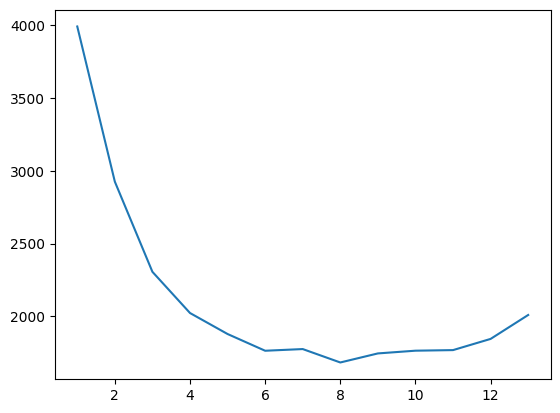

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

# Podemos graficar la evolución de la perplejidad con las épocas.
# Recordar que el valor de perplejidad del modelo trivial es el tamaño del vocabulario.
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [55]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model = keras.models.load_model('my_model.h5')

In [56]:
# Se puede usar gradio para probar el modelo
# Gradio es una herramienta muy útil para crear interfaces para ensayar modelos
# https://gradio.app/

!pip install -q gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.7/56.7 MB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.8/319.8 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.4/447.4 kB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 125.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/

In [57]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://03b32058e905bfbd67.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://03b32058e905bfbd67.gradio.live


In [58]:
#Presenta el mismo problema que con los Beatles, se repite permanentemente la palabra 'the'

In [59]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	  # generate a fixed number of words
    for _ in range(n_words):
		  # Tokenizamos
      encoded = tokenizer.texts_to_sequences([output_text])[0]

		  # Si tienen distinto largo
      encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		  # Predicción softmax
      y_hat = np.argmax(model.predict(encoded)[0,-1,:])

      # Vamos concatenando las predicciones
      out_word = ''

      # Debemos buscar en el vocabulario la palabra
      # que corresopnde al indice (y_hat) predicho por le modelo
      for word, index in tokenizer.word_index.items():
        if index == y_hat:
          out_word = word
          break

		  # Agrego las palabras a la frase predicha
      output_text += ' ' + out_word

    return output_text

In [61]:
input_text='it was mere idle talk'

generate_seq(model, tok, input_text, max_length=max_context_size, n_words=3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


'it was mere idle talk to a man'

In [63]:
#Busco una palabra que se use mucho, 'mentioned' frecuencia = 79

input_text='i haven\'t mentioned it'

generate_seq(model, tok, input_text, max_length=max_context_size, n_words=5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


"i haven't mentioned it to be a man of"

In [73]:
#Probamos un modelo solo con simple RNN, many to many con return seq = true
from keras.layers import SimpleRNN
from keras.optimizers import RMSprop
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled= scaler.fit_transform(X)  # Ajusta el escalador a tus datos ya que al correr el modelo la ppl y loss dan nan

optimizer = RMSprop(learning_rate=0.00001, clipnorm=1.0) #Ponemos este optimizer ya que queremos ajustar el LR, ya que al correr el modelo la ppl y loss dan nan
model_rnn = Sequential()
model_rnn.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_shape=(None,)))
model_rnn.add(SimpleRNN(128, return_sequences=True))  # Activar return_sequences para many-to-many
model_rnn.add(Dropout(0.2))
model_rnn.add(SimpleRNN(128, return_sequences=True))
model_rnn.add(Dense(vocab_size, activation='softmax'))  # Capa de salida

model_rnn.compile(loss=SparseCategoricalCrossentropy(), optimizer=optimizer)

model_rnn.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)              │ (None, None, 50)            │         358,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_8 (SimpleRNN)             │ (None, None, 128)           │          22,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, None, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_9 (SimpleRNN)             │ (None, None, 128)           │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, None, 7175)          │         925,575 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,340,183 (5.11 MB)

 Trainable params: 1,340,183 (5.11 MB)

 Non-trainable params: 0 (0.00 B)

In [74]:
history_ppl_simplernn = []

hist = model_rnn.fit(X_scaled, y, epochs=30, callbacks=[PplCallback(tokenized_sentences_val,history_ppl_simplernn)], batch_size=64)

#Sigue dando NaN, puede ser que sea vanishing gradients

Epoch 1/30
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: nan
 mean perplexity: nan 

1005/1005 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - loss: nan
Epoch 2/30
1000/1005 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: nan
 mean perplexity: nan 

1005/1005 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: nan
Epoch 3/30
 998/1005 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: nan
 mean perplexity: nan 

1005/1005 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: nan
Epoch 4/30
 997/1005 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: nan
 mean perplexity: nan 

1005/1005 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: nan
Epoch 5/30
1001/1005 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: nan
 mean perplexity: nan 

Stopping training...
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: nan


In [75]:
from keras.layers import GRU
#Probamos con un modelo de GRU

model_gru = Sequential()

# Capa de embedding entrenable
model_gru.add(Embedding(input_dim=vocab_size + 1, output_dim=50, input_shape=(None,)))

# Cambiamos LSTM por GRU
model_gru.add(GRU(100, return_sequences=True))

model_gru.add(GRU(100, return_sequences=True))

# Predicción de clasificación con softmax
model_gru.add(Dense(vocab_size + 1, activation='softmax'))

# Clasificación múltiple categórica --> loss = categorical_crossentropy
model_gru.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')

model_gru.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)              │ (None, None, 50)            │         358,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, None, 100)           │          45,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, None, 100)           │          60,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, None, 7176)          │         724,776 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,189,776 (4.54 MB)

 Trainable params: 1,189,776 (4.54 MB)

 Non-trainable params: 0 (0.00 B)

In [76]:
history_ppl_gru = []
hist_gru = model_gru.fit(X, y, epochs=30, callbacks=[PplCallback(tokenized_sentences_val,history_ppl_gru)], batch_size=64)

Epoch 1/30
1001/1005 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.3043


 mean perplexity: 2360.973131491359 

Saved new model!
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - loss: 4.3015
Epoch 2/30
1001/1005 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.3658
 mean perplexity: 2604.190766708327 

1005/1005 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - loss: 3.3656
Epoch 3/30
1003/1005 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.2316
 mean perplexity: 3531.187772683813 

1005/1005 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - loss: 3.2315
Epoch 4/30
1003/1005 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.1280


 mean perplexity: 2067.5009407739 

Saved new model!
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - loss: 3.1280
Epoch 5/30
1000/1005 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.0936


 mean perplexity: 2016.6713556540672 

Saved new model!
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - loss: 3.0935
Epoch 6/30
1003/1005 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.0440


 mean perplexity: 1983.0379249096952 

Saved new model!
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - loss: 3.0439
Epoch 7/30
1001/1005 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.0010
 mean perplexity: 2201.182204147027 

1005/1005 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - loss: 3.0009
Epoch 8/30
1000/1005 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.9487


 mean perplexity: 1876.0646748429278 

Saved new model!
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - loss: 2.9487
Epoch 9/30
1000/1005 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.9242


 mean perplexity: 1820.9713203783922 

Saved new model!
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - loss: 2.9242
Epoch 10/30
1003/1005 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.8927
 mean perplexity: 1883.9324958477998 

1005/1005 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - loss: 2.8927
Epoch 11/30
1000/1005 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.8666
 mean perplexity: 1827.0826193205278 

1005/1005 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - loss: 2.8665
Epoch 12/30
1004/1005 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.8313
 mean perplexity: 2994.475544950934 

1005/1005 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - loss: 2.8313
Epoch 13/30
1003/1005 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.8038
 mean perplexity: 1874.9366985433464 

1005/1005 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - loss: 2.8037
Epoch 14/30
1001/1005 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.7779
 mean perplexity: 1879.38603499212 

Stopping training...
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - loss: 2.7779


In [78]:
#Acá me doy cuenta que he estado salvando todos los modelos con el mismo nombre, no sé si se estarán reescribiendo
model_gru = keras.models.load_model('my_model.h5')

In [79]:
#Acá con GRU sigue enfocado en la palabra 'the' por lo que no sé si estoy usando mal gradio o la callback function y sigo usando el modelo original con LSTM
#o es que efectivamente no hay mucha diferencia entre el performance de LSTM y GRU con esta cantidad de datos

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model_gru.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://9dffc79f24c69cbf12.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://9dffc79f24c69cbf12.gradio.live


In [86]:
# BEAM SEARCH con el modelo original. Instancié nuevamente el modelo y lo entrené para poder usarlo acá ya que creo que al usar varias veces la callback funciton los fui pisando

# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

In [87]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens

In [89]:
# Observemos salidas con distintas temperaturas con determinista
print(decode(beam_search(model,num_beams=10,num_words=5,input="Make certain that", temp=1)[0]))
print(decode(beam_search(model,num_beams=10,num_words=5,input="Make certain that", temp=0.5)[0]))
print(decode(beam_search(model,num_beams=10,num_words=5,input="Make certain that", temp=2)[0]))
print(decode(beam_search(model,num_beams=10,num_words=5,input="Make certain that", temp=10)[0]))
print(decode(beam_search(model,num_beams=10,num_words=5,input="Make certain that", temp=20)[0]))

['make certain that i had been at the']
['make certain that i had been at the']
['make certain that i had been at the']
['make certain that i had been at the']
['make certain that i had been at the']


In [92]:
# Observemos salidas con distintas temperaturas con sto
print(decode(beam_search(model,num_beams=10,num_words=5,input="Make certain that", temp=1, mode='sto')[0]))
print(decode(beam_search(model,num_beams=10,num_words=5,input="Make certain that", temp=0.5, mode='sto')[0]))
print(decode(beam_search(model,num_beams=10,num_words=5,input="Make certain that", temp=2, mode='sto')[0]))
print(decode(beam_search(model,num_beams=10,num_words=5,input="Make certain that", temp=10, mode='sto')[0]))
print(decode(beam_search(model,num_beams=10,num_words=5,input="Make certain that", temp=20, mode='sto')[0]))

['make certain that i want to you have']
['make certain that i know ” i said']
['make certain that this very than boxes he—he—positively']
['make certain that to—shall stammered characters proprietary it—that’s']
['make certain that minute shorn mrs chimed hydrochloride']
